## Imports

In [1]:
import nltk
import re
import random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


2022-12-10 13:20:20.295741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 13:20:20.550483: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-10 13:20:20.550506: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-10 13:20:21.521077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
color_map = ListedColormap(['orange', 'green', 'red', 'magenta'])
cloud = WordCloud(background_color='white', max_words=100, colormap=color_map)

## Base de dados

In [3]:
data_base = pd.read_csv('../datasets/imdb/Keven_Almeida-IMDB Dataset.csv')

In [4]:
data_base

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
data_base.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Limpeza dos dados

In [6]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Pré processamento

In [7]:
def pre_processamento(texto):
    letras_min = re.sub('<[^<]+?>', '', texto)

    letras_min = nltk.tokenize.word_tokenize(letras_min.lower())
    stopwords = nltk.corpus.stopwords.words('english')
    stop = set(stopwords)
    
    lista = " ".join([palavra for palavra in letras_min if palavra not in stop and palavra not in string.punctuation])
    lista = re.findall(r'\b[A-zÀ-úü]+\b', lista)

    texto_limpo = " ".join([elemento for elemento in lista if not elemento.isdigit() and len(elemento) > 1])
    return texto_limpo

## Divisão dos dados

### Dados de treinamento

In [8]:
dataset = data_base.sample(frac=.5, random_state=200).reset_index(drop=True)

In [9]:
le = LabelEncoder()
dataset['sentiment'] = le.fit_transform(dataset['sentiment'])

In [10]:
training_data = dataset.sample(frac=.8, random_state=200).reset_index(drop=True)

In [11]:
training_data['review'][2]

"I first saw this movie on IFC. Which is a great network by the way to see underground films. I watched this movie and was thinking it was going to be pure drama and a story line that doesn't hold water. But it really was a worth while watch. The main character is in such rough shape, and you hate to see him deny help, but no matter what you just can't hate him. His devotion to The Beatles and John Lennon is a great metaphor for his life and the helplessness he feels. <br /><br />The atmosphere of the film is also great. At times, you feel like you can see what he sees, feel what he feels in some situations. This movie does not leave you wanting to know more, or disliking a loophole in the plot. There are NO loopholes (in my opinion). I have always been a fan of foreign films, especially now with movies being made so poorly in America. I really enjoy the foreign settings because I feel it can take you on a trip, and sometimes understand a different culture. This movie did all those thi

In [12]:
a = training_data['review'][2]


In [13]:
pre_processamento(a)

'first saw movie ifc great network way see underground films watched movie thinking going pure drama story line hold water really worth watch main character rough shape hate see deny help matter ca hate devotion beatles john lennon great metaphor life helplessness feels atmosphere film also great times feel like see sees feel feels situations movie leave wanting know disliking loophole plot loopholes opinion always fan foreign films especially movies made poorly america really enjoy foreign settings feel take trip sometimes understand different culture movie things please watch movie re new foreign films great start'

In [14]:
training_data['review'] = training_data['review'].apply(pre_processamento)

In [15]:
training_data['review']

0        nightmare elm street dream childthis bad movie...
1        ali earned fame small screen though big screen...
2        first saw movie ifc great network way see unde...
3        dear lord movie let talk special effects first...
4        hearing word mouth bad film took plunge bought...
                               ...                        
19995    lawrence olivier merle oberon two movies toget...
19996    wow remember many awful films loosely revolved...
19997    quite possibly worst christmas film ever plot ...
19998    expected better caroline munro done good films...
19999    wake personal research pending end cycle time ...
Name: review, Length: 20000, dtype: object

### Dados de teste

In [16]:
testing_data = dataset.drop(training_data.index).reset_index(drop=True)

In [17]:
testing_data['review'] = testing_data['review'].apply(pre_processamento)

## Modelo

In [18]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 1000 # M

In [19]:
class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

In [20]:
class Padder(BaseEstimator, TransformerMixin):
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

In [27]:
batch_size = 64
max_features = vocab_size + 1

def create_model(max_features):

    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS, 128))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

## Treinamento

In [28]:
sklearn_lstm = KerasClassifier(build_fn=create_model,
                               epochs=2, 
                               batch_size=32, 
                               max_features=max_features, 
                               verbose=1)

pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(training_data['review'], training_data['sentiment']);

/tmp/ipykernel_22831/3706970398.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_lstm = KerasClassifier(build_fn=create_model,
/tmp/ipykernel_22831/3434014686.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.texts_to_sequences(texts))


Epoch 1/2
625/625 [==============================] - 403s 643ms/step - loss: 0.4054 - accuracy: 0.8199
Epoch 2/2
625/625 [==============================] - 388s 620ms/step - loss: 0.1898 - accuracy: 0.9299


## Testes

In [29]:
y_preds = pipeline.predict(testing_data['review'])

/tmp/ipykernel_22831/3434014686.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.texts_to_sequences(texts))


157/157 [==============================] - 15s 97ms/step


In [30]:
accuracy_score(y_preds, testing_data['sentiment'])

0.9532

## Resultado

In [31]:
print('Test accuracy: {:.2f} %'.format(100*accuracy_score(y_preds, testing_data['sentiment'])))

print(classification_report(y_preds, testing_data['sentiment'], target_names = ['Negative','Positive']))

Test accuracy: 95.32 %
              precision    recall  f1-score   support

    Negative       0.96      0.95      0.95      2545
    Positive       0.95      0.96      0.95      2455

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



## Visualização

In [32]:
data = ' '.join(testing_data['review'])

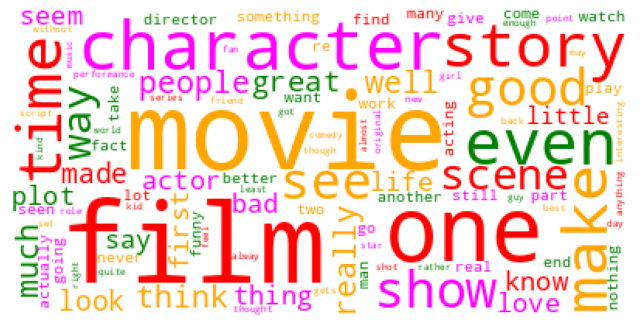

In [33]:
cloud = cloud.generate(data)
plt.figure(figsize=(8,15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [34]:
tokens= nltk.tokenize.word_tokenize(data)

In [35]:
fd= nltk.probability.FreqDist(tokens)

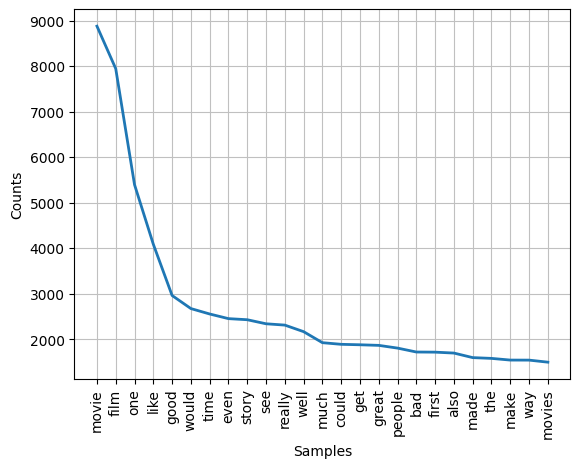

In [36]:
fd.plot(25);

In [37]:
dom_simp=nltk.Text(nltk.tokenize.word_tokenize(data))

In [38]:
dom_simp.collocations()

special effects; ever seen; low budget; year old; new york; years ago;
high school; waste time; even though; looks like; much better; martial
arts; worth watching; one best; real life; main character; production
values; science fiction; star trek; years later


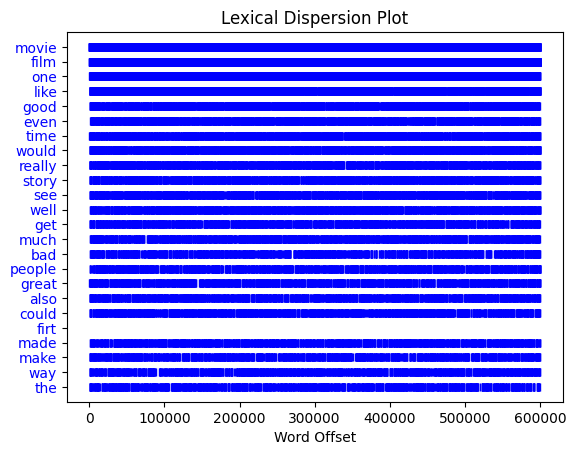

In [39]:
dom_simp.dispersion_plot([
    'movie','film','one','like','good','even','time','would',
    'really','story','see','well','get','much','bad','people',
    'great','also','could','firt','made', 'make','way','the'])